In [111]:
import os
import numpy as np
from parse import parse
import matplotlib.pyplot as plt

## Read True Data

In [2]:
mapfile = os.path.join('..', 'Documentation', 'Maps', 'TrueMap1')
truemap = []
with open(mapfile, 'r') as f:
    for _ in range(5):
        f.readline()
    for l in f:
        l = " ".join(l)
        l = l.replace('.', '0')
        l = l.replace('#', '63')
        l = l.replace('/', '0')
        l = l.replace('-', '0')
        l = l.replace('|', '0')
        l = l.replace('\\', '0')
        truemap.append(np.array(l.split(), dtype=np.int32))
truemap = np.array(truemap)
truemap = np.rot90(truemap, 3)
truemap = np.flipud(truemap)

Resize Map for printing

In [4]:
from scipy.interpolate import RegularGridInterpolator

resized_truemapp = np.zeros((1800, 1800))
stride_x = int(1800/25)
for i in range(25):
    for j in range(25):
        resized_truemapp[i*stride_x:(i+1)*stride_x, j*stride_x:(j+1)*stride_x] = truemap[i, j]

## Read Data In

Read in a map given the file of a map

In [7]:
def readInMap(mapfile):
    times = []
    mapstime = []
    with open(mapfile, 'r') as file:
        for line in file:
            if 'Map' in line:
                mapname, h, m, s = parse('{}-{}-{}-{}', line)
                times.append((h , m, s))
                if mapname == 'HumanMap':
                    readsuccess = True
                    mp = []
                    for i in range(25):
                        matline = file.readline()
                        matline = matline.replace('.', '0').replace('O','63').replace('*', '0').replace('L', '0')
                        matline = matline.split()
                        if len(matline) == 25:
                            matline = np.array(matline, dtype=np.int32)
                            mp.append(matline)
                        else:
                            readsuccess = False
                    mp = np.array(mp)
                    if readsuccess:
                        mapstime.append(mp)
                else:
                    readsuccess = True
                    mp = []
                    for i in range(25):
                        matline = file.readline()
                        matline = matline.replace('!', '-').replace('\\x0','')
                        matline = matline.split()
                        if len(matline) == 25:
                            try:
                                matline = np.array(matline, dtype=np.int32)
                            except:
                                mt = []
                                for m in matline:
                                    try:
                                        np.array(m, dtype=np.int32)
                                        mt.append(m)
                                    except:
                                        mt.append(-31)
                                matline = np.array(mt, dtype=np.int32)
                            
                            mp.append(matline)
                        else:
                            readsuccess = False
                    mp = np.array(mp)
                    if readsuccess:
                        mapstime.append(mp)
    return np.array(mapstime)

In [157]:
def readDataFile(datfile):
    positions = []
    nextmoves = []
    with open(datfile) as f:
        for line in f:
            if 'Pose' in line:
                x, y, h = parse('Pose: X: {} Y: {} H: {}', line)
                positions.append(np.array([x, y, h], dtype=np.float32))
                
            if 'NextMove' in line:
                x1, y1, x2, y2 = parse('NextMove: {}, {} -> {}, {}', line)
                nextmoves.append(np.array([x1, y1, x2, y2], dtype=np.float32))
    positions = np.array(positions) 
    positions[:, [0, 1]]*= 25/1800 # rescale
    nextmoves = np.array(nextmoves) * 25/1800 # rescale
    return positions, nextmoves

## Calculate Metrics

Coverage of set of maps over time

In [9]:
def coverage(mapstime):
    tmp = mapstime.copy()
    res = []
    for tmp in mapstime.copy():
        map_size = tmp.size
        covered = tmp[tmp >= 0].shape[0]
        res.append(covered/map_size)
    return np.array(res)

Coverage Accuracy by RMSE of seen area of maps over time

In [10]:
def coverage_accuracy(mapstime, truemap):
    tmp = mapstime.copy()
    res = []
    for tmp in mapstime:
        tmp[tmp > 100] -= 100
        seen_locs = np.where(tmp >= 0)
        diff = tmp[seen_locs] - truemap[seen_locs]
        rmse = np.sqrt(np.mean(diff * diff)) / 63
        res.append(rmse)
    return np.array(res)

Coverage Accuracy on Threshold Counts of maps over time

In [11]:
def coverage_accuracy_threshold(mapstime, thresh, truemap):
    tmp = mapstime.copy()
    res = []
    for tmp in mapstime:
        tmp[tmp > 100] -= 100
        seen_locs = np.where(tmp>= 0)
        
        seen_map_size = tmp[tmp>=0].shape[0]

        tmp[tmp >= thresh] = 63
        tmp[tmp < thresh] = 0
        diff = tmp[seen_locs] - truemap[seen_locs]
        cnt = np.count_nonzero(diff)
        res.append(cnt/seen_map_size)
    return np.array(res)

Calculate Metrics all metrics on one set of data based on final readings

In [12]:
def calculateMetricOneSet(datapath, datafoldername, truemap):
    currdatapath = os.path.join(datapath, datafoldername) # <- just read in one set
    datafiles = os.listdir(currdatapath)
    mapfile = os.path.join(currdatapath, 'map.map')
    mapstime = readInMap(mapfile)
    cov = coverage(mapstime)[-1]
    rmse = coverage_accuracy(mapstime, truemap)[-1]
    
    res = []
    for t in range(1, 63):
        thr = coverage_accuracy_threshold(mapstime, t, truemap)[-1]
        res.append(thr)
    thres = np.max(res)
    
    return (cov, rmse, thres)

Calculate Average Metrics for one given type of data

In [13]:
def calculateMetrics(datapath, dataset_tag, truemap):
    dirs = [d for d in os.listdir(datapath) if dataset_tag in d]
    covs = []
    accs = []
    thres = []
    for d in dirs:
        c, a, t = calculateMetricOneSet(datapath, d, truemap)
        covs.append(c)
        accs.append(a)
        thres.append(t)
    mean_covs = np.mean(covs)
    mean_accs = np.mean(accs)
    mean_thres = np.mean(thres)
    return(mean_covs, mean_accs, mean_thres)

## Plotting

Plot final map in a given sequence alongside truemap with associated positions path

In [55]:
def plot_final_map(mapstime, pos, truemapp, highlight_seen=False):
    mapp = mapstime[-1].copy()
    
    mapp[mapp >= 100] -= 100
    
    if highlight_seen:
        mapp[mapp >= 0] += 10
        
    mapp[mapp < 0] = 0
    
    print('Unique Values and counts', list(zip(*np.unique(mapp, return_counts=True))))
    
    fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(14, 7))
    ax[0].matshow(mapp, cmap='gist_gray', interpolation='none')
    ax[1].matshow(truemapp, cmap='gist_gray', interpolation='none')
    
    if len(positions > 0):
        ax[0].plot(pos[:, 0], pos[:, 1])
        ax[0].plot(pos[[0, -1], 0], pos[[0, -1], 1], '*')
        ax[1].plot(pos[:, 0], pos[:, 1])
        ax[1].plot(pos[[0, -1], 0], pos[[0, -1], 1], '*')
    else:
        print('No Positions Data')
    
    plt.show()

Plot maps over time on grid

In [78]:
def plot_grid(mapstime, highlight_seen=True):
    mapstime[mapstime >= 100] -= 100
    if highlight_seen:
        mapstime[mapstime >= 0] += 10   
    mapstime[mapstime < 0] = 0
    
    fig, ax = plt.subplots(6, 3 , sharex='col', sharey='row', figsize=(15, 30))
    for i in range(6):
        for j in range(3):
            try:
                ax[i, j].set_title(str(i*3 + j))
                ax[i, j].matshow(mapstime[i*3 + j], cmap='gist_gray', interpolation='none')
            except IndexError:
                continue
    plt.show()

Plot maps over time on grid with associated pose information

In [108]:
def plot_grid_with_pose(mapstime, poss, highlight_seen=True):
    mapstime[mapstime >= 100] -= 100
    if highlight_seen:
        mapstime[mapstime >= 0] += 10
    mapstime[mapstime < 0] = 0
    
    direc = np.array([poss[:,0], poss[:, 0] + np.cos(poss[:, 2]), poss[:, 1], poss[:, 1] + np.sin(poss[:, 2])]).T

    fig, ax = plt.subplots(6,3 , sharex='col', sharey='row', figsize=(15, 30))
    for i in range(6):
        for j in range(3):
            try:
                idx = i*3 + j
                ax[i, j].set_title(idx)
                ax[i, j].matshow(mapstime[idx], cmap='gist_gray', interpolation='none')
                ax[i, j].plot(direc[:idx+1, 0], direc[:idx+1, 2], 'c--x')
                ax[i, j].plot(direc[idx, [0, 1]], direc[idx, [2, 3]], 'r-')
                ax[i, j].plot(direc[idx, 0], direc[idx, 2], 'r*')
                ax[i, j].plot(direc[idx+1, 0], direc[idx+1, 2], 'm*')
            except IndexError:
                continue
    plt.show()

In [143]:
def plot_grid_with_nextmoves(mapstime, nextmove, highlight_seen=True):
    mapstime[mapstime >= 100] -= 100
    if highlight_seen:
        mapstime[mapstime >= 0] += 10
    mapstime[mapstime < 0] = 0

    fig, ax = plt.subplots(6,3 , sharex='col', sharey='row', figsize=(15, 30))
    for i in range(6):
        for j in range(3):
            try:
                idx = i*3 + j
                ax[i, j].set_title(idx)
                ax[i, j].matshow(mapstime[idx], cmap='gist_gray', interpolation='none')
                ax[i, j].plot(nextmove[:idx+1, 0], nextmove[:idx+1, 1], 'c--x')
                ax[i, j].plot(nextmove[idx, [0, 2]], nextmove[idx, [1, 3]], 'r-')
                ax[i, j].plot(nextmove[idx, 0], nextmove[idx, 1], 'r*')
                ax[i, j].plot(nextmove[idx, 2], nextmove[idx, 3], 'm*')
            except IndexError:
                continue
    plt.show()

# Analysis

Function to help get most recent datafolder

In [80]:
def get_latest_data_folder_loc_by_tag(datapath, tag):
    datafolders = os.listdir(datapath)
    latest = ''
    for d in datafolders:
        if tag in d:
            latest = d
    
    return os.path.join(datapath, latest)

Read in maps and position file of datafolder

In [127]:
def read_in_maps_and_positions(datafolder):
    datfile = os.path.join(datafolder, 'dat.data')
    mapfile = os.path.join(datafolder, 'map.map')
    mapstime = readInMap(mapfile)
    pos, nextmoves = readDataFile(datfile)
    return (mapstime, pos, nextmoves)

Calculate Metrics

In [161]:
datapath = os.path.join('..', 'data')
print(('Mean Percentage Coverage, RMSE Accuracy, Threshold Accuracy'))
print(calculateMetrics(datapath, 'Human_Readable',truemap))
print(calculateMetrics(datapath, 'Non_Belief',truemap))
print(calculateMetrics(datapath, 'Gradient_Test2',truemap))

Mean Percentage Coverage, RMSE Accuracy, Threshold Accuracy
(0.25066666666666665, 0.8333859403481173, 0.7502510652164588)
(1.0, 0.4087584556838112, 0.168)
(nan, nan, nan)


C:\Python\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Python\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Display latest data from given tag

Unique Values and counts [(0, 265), (10, 341), (13, 5), (15, 3), (16, 3), (66, 1), (72, 7)]


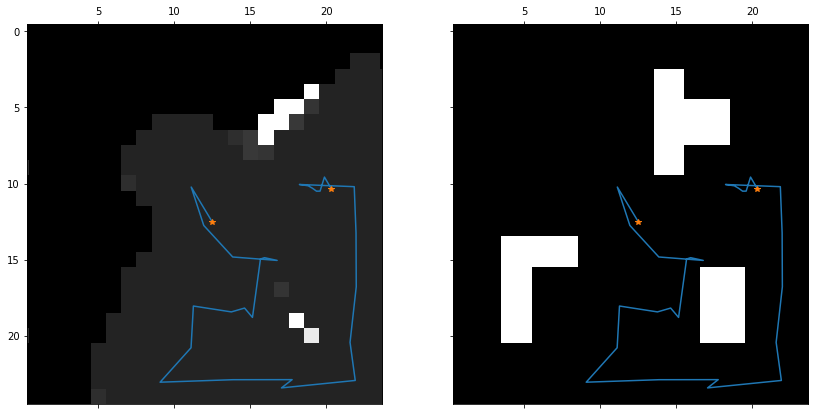

In [171]:
def display_latest_data(tag):
    datapath = os.path.join('..', 'data')
    datafolder = get_latest_data_folder_loc_by_tag(datapath, tag)
    mapstime, positions, _ = read_in_maps_and_positions(datafolder)
    plot_final_map(mapstime, positions, truemap, highlight_seen=True)
display_latest_data('Gradients_Test4')

Generate Grid

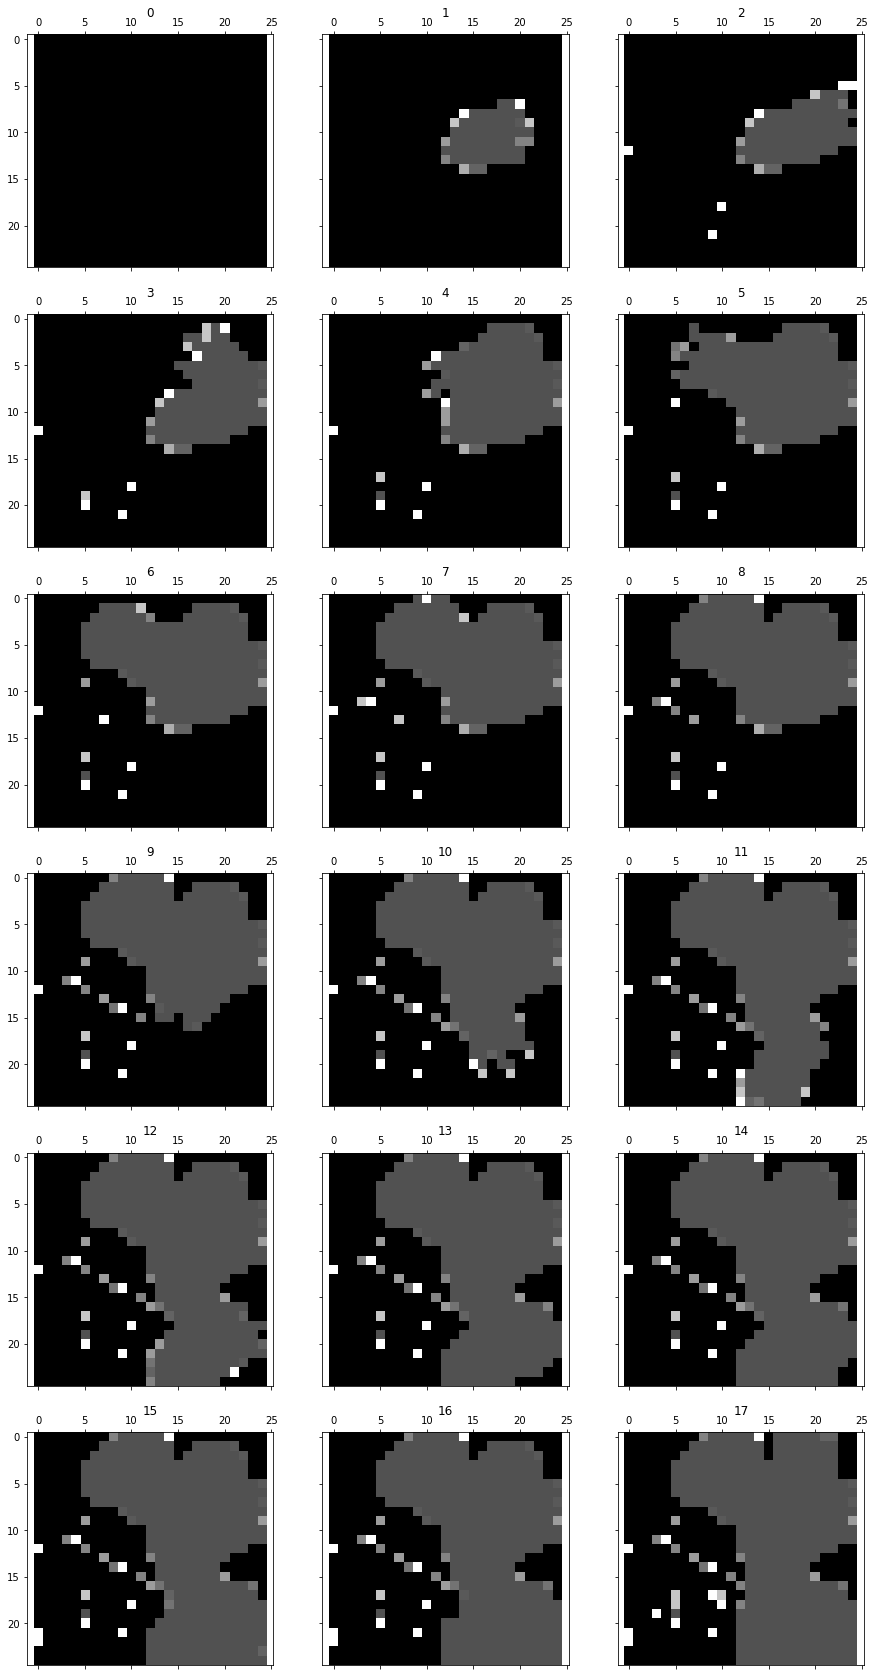

In [94]:
def display_latest_grid(tag):
    datapath = os.path.join('..', 'data')
    datafolder = get_latest_data_folder_loc_by_tag(datapath, tag)
    mapstime, positions, nextmoves = read_in_maps_and_positions(datafolder)
    plot_grid(mapstime)
display_latest_grid('Gradients_Test1_Empty')

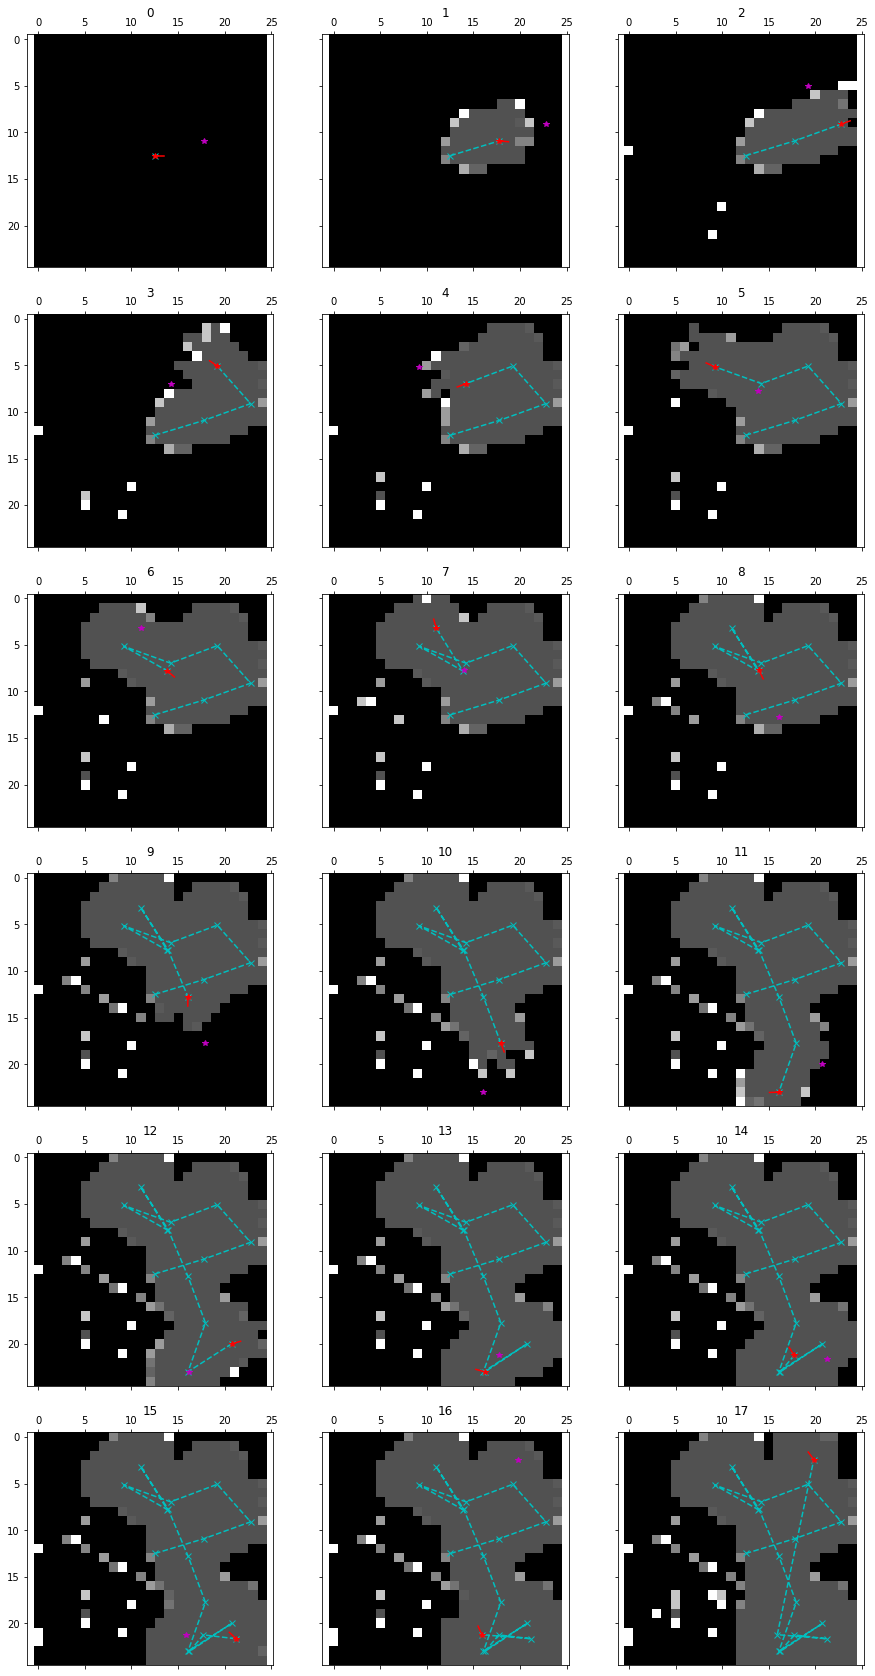

In [131]:
def display_latest_pose_grid(tag):
    datapath = os.path.join('..', 'data')
    datafolder = get_latest_data_folder_loc_by_tag(datapath, tag)
    mapstime, positions, nextmoves = read_in_maps_and_positions(datafolder)
    plot_grid_with_pose(mapstime, positions)
display_latest_pose_grid('Gradients_Test1_Empty')

(71, 4)


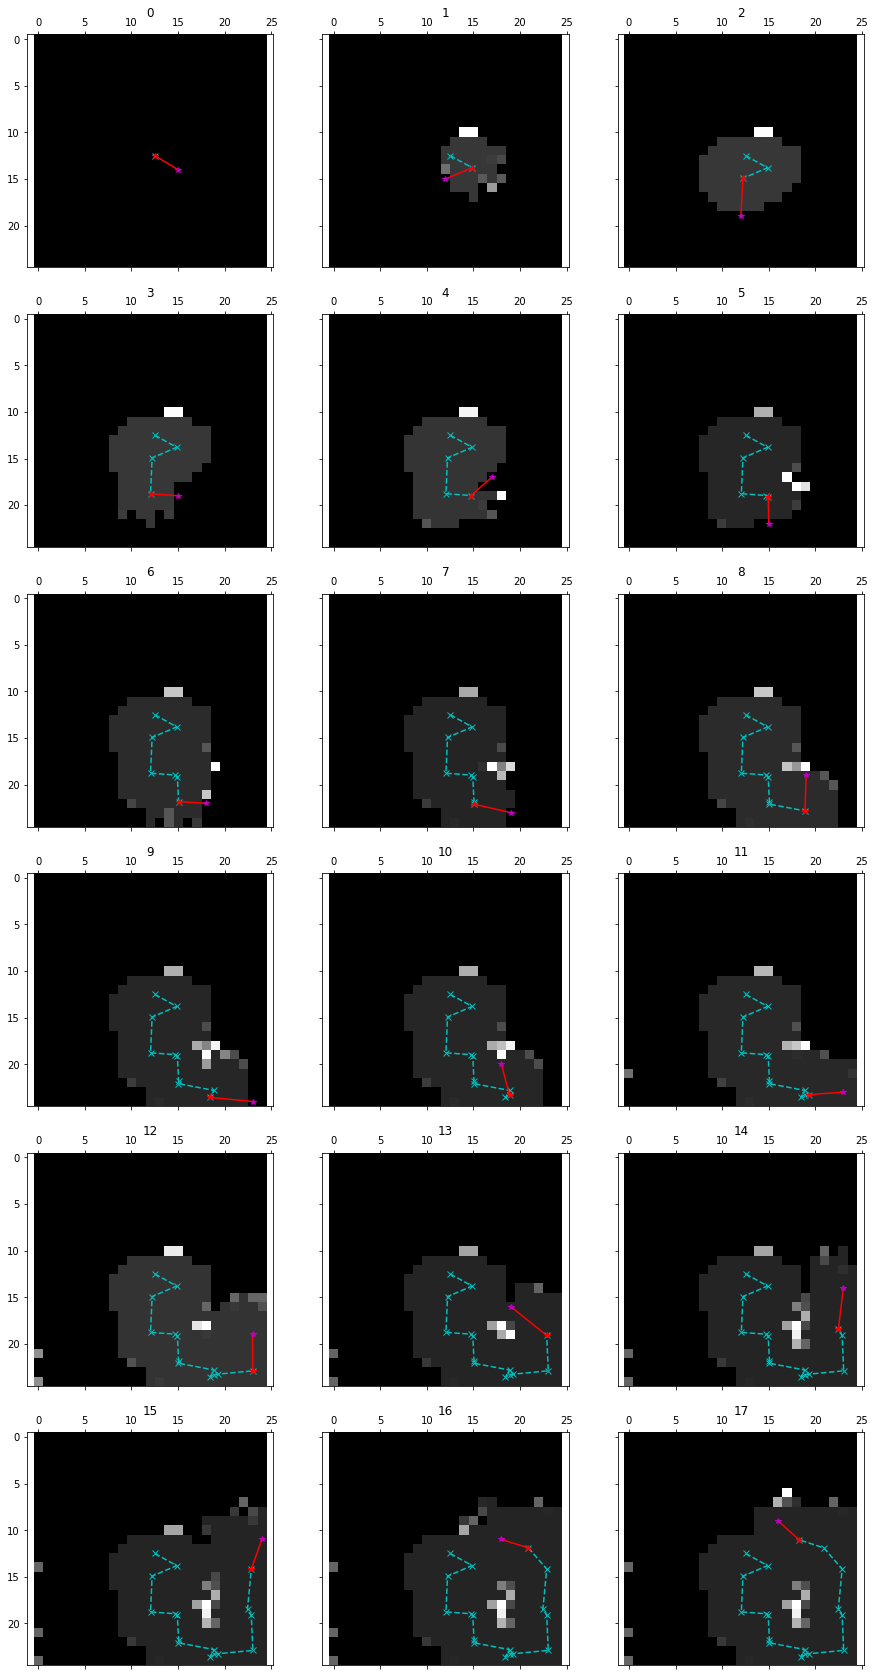

In [170]:
def display_latest_pose_grid_movement(tag):
    datapath = os.path.join('..', 'data')
    datafolder = get_latest_data_folder_loc_by_tag(datapath, tag)
    mapstime, positions, nextmoves = read_in_maps_and_positions(datafolder)
    print(nextmoves.shape)
    plot_grid_with_nextmoves(mapstime, nextmoves)
display_latest_pose_grid_movement('Gradients_Test3_Long_Duration')